In [55]:
%pip install tqdm
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 3.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [57]:
import pandas as pd
import numpy as np
import json
from collections import defaultdict, namedtuple, OrderedDict
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

tqdm.pandas()

In [2]:
rating_csv = 'dataset/ratings.csv'
movies_csv = 'dataset/movies.csv'

# Preprocessing

In [3]:
ratings_df = pd.read_csv(rating_csv)
ratings_df.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [4]:
movies_df = pd.read_csv(movies_csv)
movies_df.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


## Cleaning

In [5]:
ratings_df = ratings_df.drop(labels=['timestamp'], axis=1)

In [6]:
ratings_df.head(100)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
95,1,1445,3.0
96,1,1473,4.0
97,1,1500,4.0
98,1,1517,5.0


## Transactional dataset

In [7]:
ratings_df = ratings_df[ratings_df['rating'] > 2]

In [8]:
ratings_df.head(100)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
96,1,1473,4.0
97,1,1500,4.0
98,1,1517,5.0
99,1,1552,4.0


In [9]:
user_counts = pd.DataFrame(ratings_df['userId'].value_counts().sort_values())
user_counts

,count
userId,
442,2
508,6
293,10
329,11
431,13
...,...
610,1233
448,1255
599,1794


In [10]:
active_users = user_counts[user_counts['count'] > 10].index
ratings_df = ratings_df[ratings_df['userId'].isin(active_users)]

In [11]:
ratings_df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [12]:
transactions = (ratings_df
                 .groupby('userId')['movieId']
                 .apply(lambda x: (list(set(x)), len(x)))
                 .reset_index())

transactions[['movies', 'count']] = pd.DataFrame(transactions['movieId'].tolist(), index=transactions.index)
transactions.drop(columns=['movieId'], inplace=True)

transactions

,userId,movies,count
0,1,"[1024, 1, 1025, 3, 2048, 1029, 6, 1030, 1031, ...",226
1,2,"[115713, 122882, 48516, 91529, 80906, 91658, 1...",28
2,3,"[70946, 2851, 5764, 4518, 26409, 7991, 1275, 2...",18
3,4,"[1025, 3079, 3083, 21, 1046, 2583, 4121, 538, ...",167
4,5,"[1, 515, 261, 265, 527, 531, 21, 150, 534, 153...",40
...,...,...,...
602,606,"[1, 8195, 6148, 7, 11, 69644, 4109, 15, 17, 18...",1070
603,607,"[1, 517, 2053, 2054, 1544, 3081, 11, 1036, 257...",174
604,608,"[1, 4105, 10, 6157, 16, 21, 31, 32, 2080, 34, ...",670
605,609,"[1, 137, 10, 650, 1161, 786, 150, 288, 161, 10...",37


In [13]:
transactions.to_csv('transaction_dataset.csv', header=True)

In [14]:
transactions = pd.read_csv('transaction_dataset.csv')
transactions.head(10)

,Unnamed: 0,userId,movies,count
0,0,1,"[1024, 1, 1025, 3, 2048, 1029, 6, 1030, 1031, ...",226
1,1,2,"[115713, 122882, 48516, 91529, 80906, 91658, 1...",28
2,2,3,"[70946, 2851, 5764, 4518, 26409, 7991, 1275, 2...",18
3,3,4,"[1025, 3079, 3083, 21, 1046, 2583, 4121, 538, ...",167
4,4,5,"[1, 515, 261, 265, 527, 531, 21, 150, 534, 153...",40
5,5,6,"[2, 3, 4, 5, 6, 7, 8, 515, 10, 11, 516, 13, 52...",294
6,6,7,"[1, 8207, 34319, 42002, 3114, 1584, 50, 58, 16...",111
7,7,8,"[2, 11, 141, 527, 21, 150, 282, 539, 32, 34, 2...",43
8,8,9,"[3328, 4993, 5378, 5890, 5893, 1674, 5902, 373...",34
9,9,10,"[7169, 33794, 6155, 54286, 72720, 86548, 30749...",119


In [15]:
def split_movies(movies, test_size=0.2):
    movies = json.loads(movies)  # Convert set to list
    split_idx = int(len(movies) * (1 - test_size))  # Index for 80/20 split
    train_movies = set(movies[:split_idx])  # First 80% for training
    test_movies = set(movies[split_idx:])  # Last 20% for test
    return (train_movies, test_movies)

transactions[['trainMovies', 'testMovies']] = transactions['movies'].apply(
    lambda movies: pd.Series(split_movies(movies))
)
transactions = transactions.drop(labels='movies', axis=1)

In [16]:
transactions.head(10)

,Unnamed: 0,userId,count,trainMovies,testMovies
0,0,1,226,"{1024, 1, 1025, 3, 2048, 1029, 6, 1030, 1031, ...","{2459, 3489, 1954, 1445, 2470, 423, 4006, 2985..."
1,1,2,28,"{115713, 122882, 48516, 91529, 80906, 91658, 1...","{46970, 80489, 71535, 74458, 6874, 8798}"
2,2,3,18,"{70946, 2851, 5764, 4518, 3703, 26409, 2288, 8...","{1371, 5181, 7899, 5919}"
3,3,4,167,"{1025, 3079, 3083, 21, 1046, 2583, 4121, 538, ...","{904, 908, 910, 912, 914, 919, 920, 1947, 3996..."
4,4,5,40,"{1, 515, 261, 265, 527, 531, 21, 150, 534, 153...","{608, 232, 364, 110, 367, 247, 253, 349}"
5,5,6,294,"{2, 3, 4, 5, 6, 7, 8, 515, 10, 11, 516, 13, 52...","{509, 510, 405, 410, 412, 415, 416, 505, 419, ..."
6,6,7,111,"{1, 34319, 8207, 42002, 3114, 1584, 50, 58, 16...","{4995, 3977, 33162, 6539, 920, 3994, 924, 1954..."
7,7,8,43,"{2, 11, 141, 527, 21, 150, 282, 539, 32, 34, 2...","{235, 364, 236, 110, 367, 252, 377, 380, 253}"
8,8,9,34,"{3328, 4993, 5378, 5890, 5893, 1674, 5902, 373...","{5481, 5872, 6001, 371, 627, 1270, 2300}"
9,9,10,119,"{7169, 33794, 6155, 54286, 72720, 86548, 30749...","{103335, 103339, 78772, 81845, 104374, 81847, ..."


In [17]:
inp = transactions[['userId', 'trainMovies']]
inp.columns = ['Id', 'tr']
n_inp = inp.shape[0]

inp


,Id,tr
0,1,"{1024, 1, 1025, 3, 2048, 1029, 6, 1030, 1031, ..."
1,2,"{115713, 122882, 48516, 91529, 80906, 91658, 1..."
2,3,"{70946, 2851, 5764, 4518, 3703, 26409, 2288, 8..."
3,4,"{1025, 3079, 3083, 21, 1046, 2583, 4121, 538, ..."
4,5,"{1, 515, 261, 265, 527, 531, 21, 150, 534, 153..."
...,...,...
602,606,"{1, 8195, 6148, 7, 11, 69644, 4109, 15, 17, 18..."
603,607,"{1, 2053, 517, 2054, 1544, 3081, 11, 1036, 257..."
604,608,"{1, 4105, 10, 6157, 16, 21, 31, 32, 2080, 34, ..."
605,609,"{1, 137, 10, 1161, 650, 786, 150, 288, 161, 10..."


In [18]:
min_sup = 50
min_conf = 0.1

## FPTree

### Construct FPTree

In [19]:
class FPNode:
    def __init__(self, item, count, parent) -> None:
        self.item = item
        self.parent = parent
        self.children = {}
        self.link = None
        self.count = count

    def increment(self, count):
        self.count = self.count + count

    def pretty_print(self):
        print(f'({self.item}-{self.count})[ ', end='')
        for id, ch in self.children.items():
            ch.pretty_print()
        print(' ], ', end='')


class FPTreeBase:
    def __init__(self, transactions, freq_1_itemsets, min_sup) -> None:
        self.transactions = transactions
        self.freq_1_itemsets = freq_1_itemsets
        self.min_sup = min_sup
        self.header_table = defaultdict(list)
        self.root = None

    def _build_tree(self):
        root = FPNode(None, 1, None)
        for transaction in self.transactions:
            self._insert_transaction(root, transaction)
        self.root = root
        return root

    def _insert_transaction(self, node, transaction):
        if len(transaction) == 0:
            return

        [first_item, freq] = transaction[0]
        if first_item in node.children:
            node.children[first_item].increment(freq)
        else:
            new_node = FPNode(first_item, freq, node)
            node.children[first_item] = new_node
            self.header_table[first_item].append(new_node)

        # Recursively insert the rest of the transaction
        remaining_tr = transaction[1:]
        self._insert_transaction(node.children[first_item], remaining_tr)

    def _prefix_path(self, node):
        path = []
        while node and node.item is not None:
            path.append(node.item)
            node = node.parent
        return path[::-1]

    def mine_patterns(self, depth=0):
        patterns = {}
        final_cond_base = []
        # Process items in reverse order of their frequency (from the header table)
        for item in reversed(self.freq_1_itemsets):
            if (item not in self.header_table):
                continue

            conditional_patterns = []
            for node in self.header_table[item]:
                path = self._prefix_path(node)
                # print('Path for ', item, ':', path[1:10],'...')
                if path:
                    conditional_patterns.append(
                        [[p, node.count] for p in path])

            # print(f'Conditional Base Patterns I{item}:', conditional_patterns)
            leaf_item_freq = OrderedDict()
            for pattern in conditional_patterns:
                for [node, freq] in pattern:
                    if node not in leaf_item_freq:
                        leaf_item_freq[node] = freq
                    else:
                        leaf_item_freq[node] += freq

            # print(leaf_item_freq)
            leaf_item_freq = {k: v for k,
                              v in leaf_item_freq.items() if v >= self.min_sup}
            # print(leaf_item_freq)

            filtered_patterns = []
            for pattern in conditional_patterns:
                fil = list(filter(lambda p: p[0] in leaf_item_freq, pattern))
                filtered_patterns.append(fil)
            conditional_patterns = filtered_patterns

            for pattern in conditional_patterns:
                temp = []
                for [node, freq] in pattern:
                    if (node in leaf_item_freq):
                        temp.append([node, freq])

                final_cond_base.append(temp)

            # print(f'Final Conditional Base Patterns I{item}:', conditional_patterns)
            if (len(conditional_patterns) == 1):
                if (conditional_patterns[0][0][1] >= self.min_sup):
                    patterns[tuple(sorted(
                        [node for node, freq in conditional_patterns[0]]))] = conditional_patterns[0][0][1]
            elif (len(final_cond_base) >= 2):
                print('Recursing >>>>>>>>', depth+1)
                conditional_tree = FPTreeBase(
                    [p[0:len(p)-1] for p in conditional_patterns], self.freq_1_itemsets, self.min_sup)
                conditional_tree._build_tree()

            #   conditional_tree.root.pretty_print()
            #   print()

                conditional_patterns_freq = conditional_tree.mine_patterns(
                    depth=depth+1)
                for pattern, count in conditional_patterns_freq.items():
                    patterns[tuple(sorted(list(pattern) + [item]))] = count
                print('BackTracking <<<<<<<<')
            #   print(f'Patterns ending in I{item}:', conditional_patterns_freq)

            item_count = sum([pattern[0][1]
                             for pattern in conditional_patterns])
            if item_count >= self.min_sup:
                patterns[(item,)] = item_count

        # unique_cond_base_set = set(map(tuple,final_cond_base))
        # unique_cond_base_list =list(unique_cond_base_set)

        return patterns


class FPTree(FPTreeBase):
    def __init__(self, transactions, min_sup) -> None:
        freq_1_itemsets, freq_1_df = self.__generate_freq_1_itemsets(transactions)
        self.freq_1_itemsets = freq_1_itemsets
        self.freq_1_df = freq_1_df
        transactions = self.__filter_sort_transactions(
            transactions, freq_1_itemsets)

        new_transactions = []
        for transaction in transactions:
            new_transactions.append([[node, 1] for node in transaction])

        super().__init__(new_transactions, freq_1_itemsets, min_sup)

    def __generate_freq_1_itemsets(self, transactions):
        it_set_1 = set()
        for tr in transactions:
            it_set_1 = it_set_1.union(set(tr))
        it_set_1 = list(it_set_1)
        print('distinct:', len(it_set_1))

        mp = {}
        for tr in transactions:
            for mId in tr:
                if mId in mp:
                    mp[mId] += 1
                else:
                    mp[mId] = 1

        it_df_1 = pd.DataFrame(list(mp.items()), columns=['mId', 'Support'])
        it_df_1 = it_df_1.sort_values(by='Support', ascending=False)
        it_df_1 = it_df_1[it_df_1['Support'] >= min_sup]
        print('distinct movies after filtering minsup:', it_df_1.shape[0])

        it_set_1 = it_df_1['mId'].tolist()
        return it_set_1, it_df_1

    def __filter_sort_transactions(self, transactions, freq_1_itemsets):
        def fn(movies):
            movies = list(movies)
            filtered_movies = filter(lambda x: (x in freq_1_itemsets), movies)
            sorted_movies = sorted(
                filtered_movies, key=lambda x: freq_1_itemsets.index(x))
            return sorted_movies

        transactions = [fn(tr) for tr in transactions]
        return transactions

    def fit(self):
        self.root = self._build_tree()
        return self.freq_1_df
    
    def mine_patterns(self):
        patterns = super().mine_patterns()
        return patterns, self.freq_1_df

In [20]:
fpTree = FPTree(inp['tr'].tolist(), min_sup)
fpTree.fit()
print('FItting done')
patterns, freq_1_df = fpTree.mine_patterns()
print('Found', len(patterns), 'Frequent itemsets')

patterns = pd.DataFrame(list(patterns.items()), columns=['itemset','Support'])
patterns = patterns.sort_values(by='Support', ascending=False)
patterns = patterns.reset_index(drop=True)
patterns

distinct: 7762
distinct movies after filtering minsup: 264
FItting done
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
BackTracking <<<<<<<<
Recursing >>>>>>>> 1
Back

,itemset,Support
0,"(318,)",307
1,"(296,)",289
2,"(593,)",265
3,"(2571,)",264
4,"(356,)",240
...,...,...
68332,"(260, 296, 858, 1198, 2762)",50
68333,"(260, 589, 858, 1198, 2762)",50
68334,"(858, 1196, 1198, 2571, 2762)",50
68335,"(260, 858, 1196, 1198, 2571, 2762)",50


In [21]:
patterns.to_csv('frequent-itemsets.csv',index=False,header=True, encoding='utf-8')
freq_1_df.to_csv('1-itemset-frequency.csv', index=False, header=True, encoding='utf-8')

In [22]:
import ast

freq_1_df = pd.read_csv('1-itemset-frequency.csv')
patterns = pd.read_csv('frequent-itemsets.csv')
patterns['movies'] = patterns['itemset'].apply(lambda x: set(ast.literal_eval(x)))
patterns.drop(columns='itemset', axis=1, inplace=True)
patterns

,Support,movies
0,307,{318}
1,289,{296}
2,265,{593}
3,264,{2571}
4,240,{356}
...,...,...
68332,50,"{260, 296, 2762, 1198, 858}"
68333,50,"{260, 2762, 589, 1198, 858}"
68334,50,"{2762, 2571, 1196, 1198, 858}"
68335,50,"{260, 2762, 2571, 1196, 1198, 858}"


In [23]:
association_df = []

for id, row in patterns.iterrows():
  support, movies = row
  if(len(movies) > 1):
    for mv in movies:
      X = mv
      Y = movies.copy()
      Y.discard(X)
      association_df.append([X, Y, support])

association_df = pd.DataFrame(association_df, columns=['X', 'Y', 'Support'])
association_df = association_df.sort_values(by=['Support'], ascending=False)

freq_1_df['X Freq'] = freq_1_df['Support']
freq_1_df['X'] = freq_1_df['mId']
freq_1_df.drop(columns=['mId', 'Support'], axis=1,inplace=True)

association_df = pd.merge(association_df, freq_1_df, on='X', how='left')
association_df['Confidence'] = association_df['Support']/association_df['X Freq']
association_df = association_df[association_df['Confidence'] >= min_conf]

association_df['Y_formatted'] = association_df['Y'].apply(lambda y: str(y))
association_df['Rule'] = association_df['X'].astype(str) + ' -> ' + association_df['Y_formatted']

association_df = association_df.drop(columns=['Y_formatted'], axis=1)

association_df

,X,Y,Support,X Freq,Confidence,Rule
0,318,{296},209,307,0.680782,318 -> {296}
1,296,{318},209,289,0.723183,296 -> {318}
2,296,{593},194,289,0.671280,296 -> {593}
3,593,{296},194,265,0.732075,593 -> {296}
4,318,{593},189,307,0.615635,318 -> {593}
...,...,...,...,...,...,...
296937,1197,"{260, 1210, 2858, 2571, 1196}",50,139,0.359712,"1197 -> {260, 1210, 2858, 2571, 1196}"
296938,1210,"{260, 2858, 2571, 1196, 1197}",50,186,0.268817,"1210 -> {260, 2858, 2571, 1196, 1197}"
296939,593,"{2571, 1213, 1214}",50,265,0.188679,"593 -> {2571, 1213, 1214}"
296940,2571,"{593, 1213, 1214}",50,264,0.189394,"2571 -> {593, 1213, 1214}"


In [24]:
association_df.to_csv('association_rules.csv', index=False,header=True, encoding='utf-8')

In [25]:
support_sorted_df = association_df.sort_values(by='Support', ascending=False).reset_index(drop=True)
support_sorted_df = support_sorted_df.head(100)
support_sorted_df

,X,Y,Support,X Freq,Confidence,Rule
0,296,{318},209,289,0.723183,296 -> {318}
1,318,{296},209,307,0.680782,318 -> {296}
2,296,{593},194,289,0.671280,296 -> {593}
3,593,{296},194,265,0.732075,593 -> {296}
4,593,{318},189,265,0.713208,593 -> {318}
...,...,...,...,...,...,...
95,1210,"{2571, 260}",131,186,0.704301,"1210 -> {2571, 260}"
96,2571,"{1210, 260}",131,264,0.496212,"2571 -> {1210, 260}"
97,296,{1196},131,289,0.453287,296 -> {1196}
98,260,"{1210, 2571}",131,239,0.548117,"260 -> {1210, 2571}"


In [26]:
support_sorted_df.to_csv('support_sorted_top_100.csv', index=False,header=True, encoding='utf-8')

top_100_support_list = support_sorted_df['Rule'].tolist()
with open('3_top100RulesBySup.txt', 'w+') as f:
  f.write('\n'.join(top_100_support_list))

In [27]:
confidence_sorted_df = association_df.sort_values(by='Confidence', ascending=False).reset_index(drop=True)
confidence_sorted_df = confidence_sorted_df.head(100)
confidence_sorted_df

,X,Y,Support,X Freq,Confidence,Rule
0,33493,{2571},61,63,0.968254,33493 -> {2571}
1,33493,{260},61,63,0.968254,33493 -> {260}
2,33493,{1196},61,63,0.968254,33493 -> {1196}
3,6934,{2571},55,57,0.964912,6934 -> {2571}
4,33493,"{2571, 1196}",60,63,0.952381,"33493 -> {2571, 1196}"
...,...,...,...,...,...,...
95,1258,{296},79,94,0.840426,1258 -> {296}
96,4973,{356},68,81,0.839506,4973 -> {356}
97,2683,{260},68,81,0.839506,2683 -> {260}
98,1291,{1196},114,136,0.838235,1291 -> {1196}


In [28]:
confidence_sorted_df.to_csv('confidence_sorted_top_100.csv', index=False,header=True, encoding='utf-8')

top_100_support_list = support_sorted_df['Rule'].tolist()
with open('3_top100RulesByConf.txt', 'w+') as f:
  f.write('\n'.join(top_100_support_list))

In [29]:
support_sorted_df['Y'] = support_sorted_df['Y'].apply(lambda x: tuple(sorted(list(x))))
confidence_sorted_df['Y'] = confidence_sorted_df['Y'].apply(lambda x: tuple(sorted(list(x))))

In [30]:
common_df = pd.merge(support_sorted_df, confidence_sorted_df, how='inner')
common_df = common_df.sort_values(by='Confidence', ascending=False).reset_index(drop=True)
common_df

,X,Y,Support,X Freq,Confidence,Rule
0,1196,"(260,)",182,204,0.892157,1196 -> {260}
1,1210,"(260,)",165,186,0.887097,1210 -> {260}


# Task 3

In [31]:
association_df = association_df.sort_values(by='Confidence', ascending=False).reset_index(drop=True)

In [71]:
def get_precision_recoil(trainMovies, testMovies, num_rules):
    # print(f'..{id}',end='')
    # print(trainMovies, testMovies)
    predicted = set()
    for mv in trainMovies:
      top_rules = association_df[association_df['X'] == mv].head(num_rules)
      top_Y = top_rules['Y'].tolist()
      
      union_Y = set()
      for Y in top_Y:
        union_Y = union_Y.union(Y)
      
      predicted = predicted.union(union_Y)
    
    recommended_movies = predicted.difference(trainMovies)
    
    true_positives = len(recommended_movies.intersection(testMovies))
    precision = true_positives / len(recommended_movies) if len(recommended_movies)!=0 else 0
    recall = true_positives / len(testMovies) if len(testMovies)!=0 else 0

    return precision, recall

In [72]:
def get_avg_precision_recoil(num_rules):
  transactions[['precision','recall']] = transactions.progress_apply(
      lambda row: pd.Series(get_precision_recoil(row['trainMovies'], row['testMovies'], num_rules)),
      axis=1
  )
  
  avg_precision = transactions['precision'].mean()
  avg_recall = transactions['recall'].mean()
  
  return avg_precision, avg_recall

In [61]:
num_rules_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100]
  
results = []
  
for num_rules in num_rules_list:
  print(f'For Num Rules: {num_rules}')
  print()
  precision, recall = get_avg_precision_recoil(num_rules)
  print('-----------------------------------')
  print('Avg precision:', precision)
  print('Avg Recall', recall)
  print('---------------------------')

  results.append([num_rules, precision, recall])

results = pd.DataFrame(results, columns=['Num Rules', 'Precision', 'Recall'])

For Num Rules: 1



100%|██████████| 607/607 [01:28<00:00,  6.88it/s]


-----------------------------------
Avg precision: 0.028481211265395778
Avg Recall 0.010917930935748428
---------------------------
For Num Rules: 2



100%|██████████| 607/607 [01:37<00:00,  6.23it/s]


-----------------------------------
Avg precision: 0.04681838388592919
Avg Recall 0.01797526373256895
---------------------------
For Num Rules: 3



100%|██████████| 607/607 [01:33<00:00,  6.48it/s]


-----------------------------------
Avg precision: 0.043175180119166934
Avg Recall 0.023196835293046933
---------------------------
For Num Rules: 4



100%|██████████| 607/607 [01:33<00:00,  6.52it/s]


-----------------------------------
Avg precision: 0.03561924986966173
Avg Recall 0.024708515298282517
---------------------------
For Num Rules: 5



100%|██████████| 607/607 [01:23<00:00,  7.27it/s]


-----------------------------------
Avg precision: 0.03007554703697741
Avg Recall 0.027317685370385043
---------------------------
For Num Rules: 6



100%|██████████| 607/607 [01:16<00:00,  7.93it/s]


-----------------------------------
Avg precision: 0.028226632456183464
Avg Recall 0.027962733822659482
---------------------------
For Num Rules: 7



100%|██████████| 607/607 [01:20<00:00,  7.50it/s]


-----------------------------------
Avg precision: 0.02744362910675946
Avg Recall 0.028393972140556004
---------------------------
For Num Rules: 8



100%|██████████| 607/607 [01:41<00:00,  5.99it/s]


-----------------------------------
Avg precision: 0.02994905041777987
Avg Recall 0.03459623290530056
---------------------------
For Num Rules: 9



100%|██████████| 607/607 [01:42<00:00,  5.90it/s]


-----------------------------------
Avg precision: 0.028107755487139188
Avg Recall 0.03568166387887859
---------------------------
For Num Rules: 10



100%|██████████| 607/607 [01:41<00:00,  5.97it/s]


-----------------------------------
Avg precision: 0.02673397536855032
Avg Recall 0.03676688654564986
---------------------------
For Num Rules: 50



100%|██████████| 607/607 [01:41<00:00,  5.99it/s]


-----------------------------------
Avg precision: 0.03458406235899718
Avg Recall 0.0997420571155242
---------------------------
For Num Rules: 100



100%|██████████| 607/607 [01:52<00:00,  5.41it/s]

-----------------------------------
Avg precision: 0.028662824982221054
Avg Recall 0.10884641542081018
---------------------------


In [65]:
results.to_csv('avg_precision_recall.csv', index=False, header=True, encoding='utf-8')

In [66]:
results = pd.read_csv('avg_precision_recall.csv')

In [67]:
results

,Num Rules,Precision,Recall
0,1,0.028481,0.010918
1,2,0.046818,0.017975
2,3,0.043175,0.023197
3,4,0.035619,0.024709
4,5,0.030076,0.027318
5,6,0.028227,0.027963
6,7,0.027444,0.028394
7,8,0.029949,0.034596
8,9,0.028108,0.035682
9,10,0.026734,0.036767


In [69]:
results = results[results['Num Rules'] <= 10]

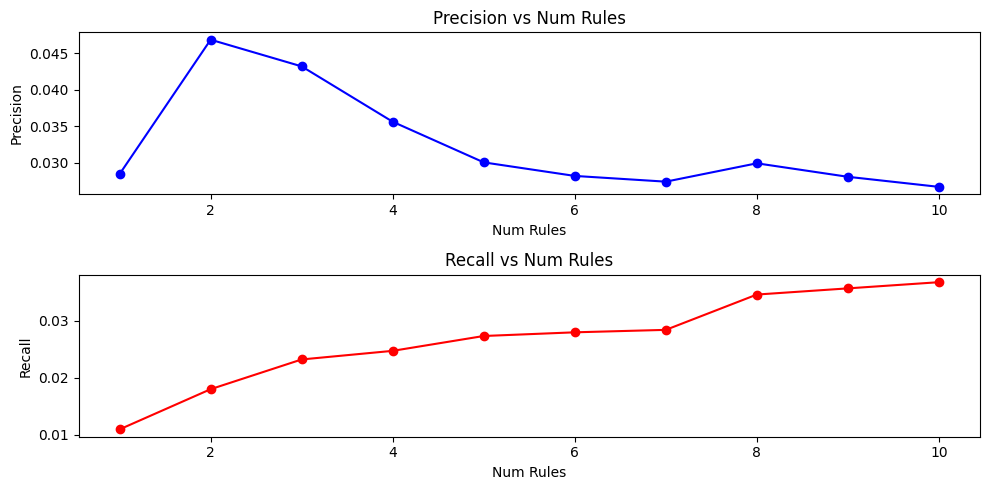

In [70]:
plt.figure(figsize=(10, 5))

# First plot for Precision
plt.subplot(2, 1, 1)
plt.plot(results['Num Rules'], results['Precision'], marker='o', color='b')
plt.title('Precision vs Num Rules')
plt.xlabel('Num Rules')
plt.ylabel('Precision')

# Second plot for Recall
plt.subplot(2, 1, 2)
plt.plot(results['Num Rules'], results['Recall'], marker='o', color='r')
plt.title('Recall vs Num Rules')
plt.xlabel('Num Rules')
plt.ylabel('Recall')

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plots
plt.show()

# Task 4

In [83]:
import random
random_seed = 4
random.seed(random_seed)

num_rules = 8 # selected because of good balance between precision and recall
num_samples = 100

all_uids = transactions['userId'].tolist()
sampled_uids = random.sample(all_uids, num_samples)

sample = transactions[transactions['userId'].isin(sampled_uids)].copy()

sample[['precision','recall']] = sample.progress_apply(
      lambda row: pd.Series(get_precision_recoil(row['trainMovies'], row['testMovies'], num_rules)),
      axis=1
  )

sample

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


,Unnamed: 0,userId,count,trainMovies,testMovies,precision,recoil,recall
7,7,8,43,"{2, 11, 141, 527, 21, 150, 282, 539, 32, 34, 2...","{235, 364, 236, 110, 367, 252, 377, 380, 253}",0.000000,0.000000,0.000000
18,18,19,357,"{2048, 1, 2, 3, 513, 2054, 3081, 2571, 2060, 1...","{3712, 1920, 1921, 1923, 1805, 1552, 1681, 181...",0.000000,0.000000,0.000000
20,20,21,380,"{1, 2, 122882, 2052, 111617, 122886, 33794, 54...","{53121, 53125, 63113, 51084, 3984, 89745, 9793...",0.000000,0.000000,0.000000
26,26,27,109,"{1, 2, 2565, 2054, 1035, 2059, 2080, 3104, 34,...","{1947, 3489, 421, 1960, 2478, 3508, 3519, 1474...",0.000000,0.000000,0.000000
43,43,44,38,"{1, 3, 260, 6, 648, 780, 141, 1552, 785, 18, 6...","{104, 1517, 494, 112, 1393, 889, 891, 1405}",0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
560,560,564,145,"{111617, 69122, 76293, 7173, 37384, 111113, 11...","{46976, 1923, 51084, 84374, 136598, 143257, 90...",0.000000,0.000000,0.000000
562,562,566,63,"{256, 2, 261, 7, 648, 265, 10, 11, 266, 141, 7...","{736, 356, 357, 236, 110, 367, 368, 497, 500, ...",0.090909,0.076923,0.076923
584,584,588,45,"{3, 6, 778, 10, 527, 16, 147, 21, 22, 150, 25,...","{480, 225, 356, 364, 110, 380, 733, 766, 223}",0.222222,0.000000,0.222222
595,595,599,1794,"{1, 2, 122882, 6, 7, 122886, 10, 11, 81932, 12...","{169984, 137218, 6157, 6162, 79895, 6185, 6188...",0.200000,0.000000,0.002786


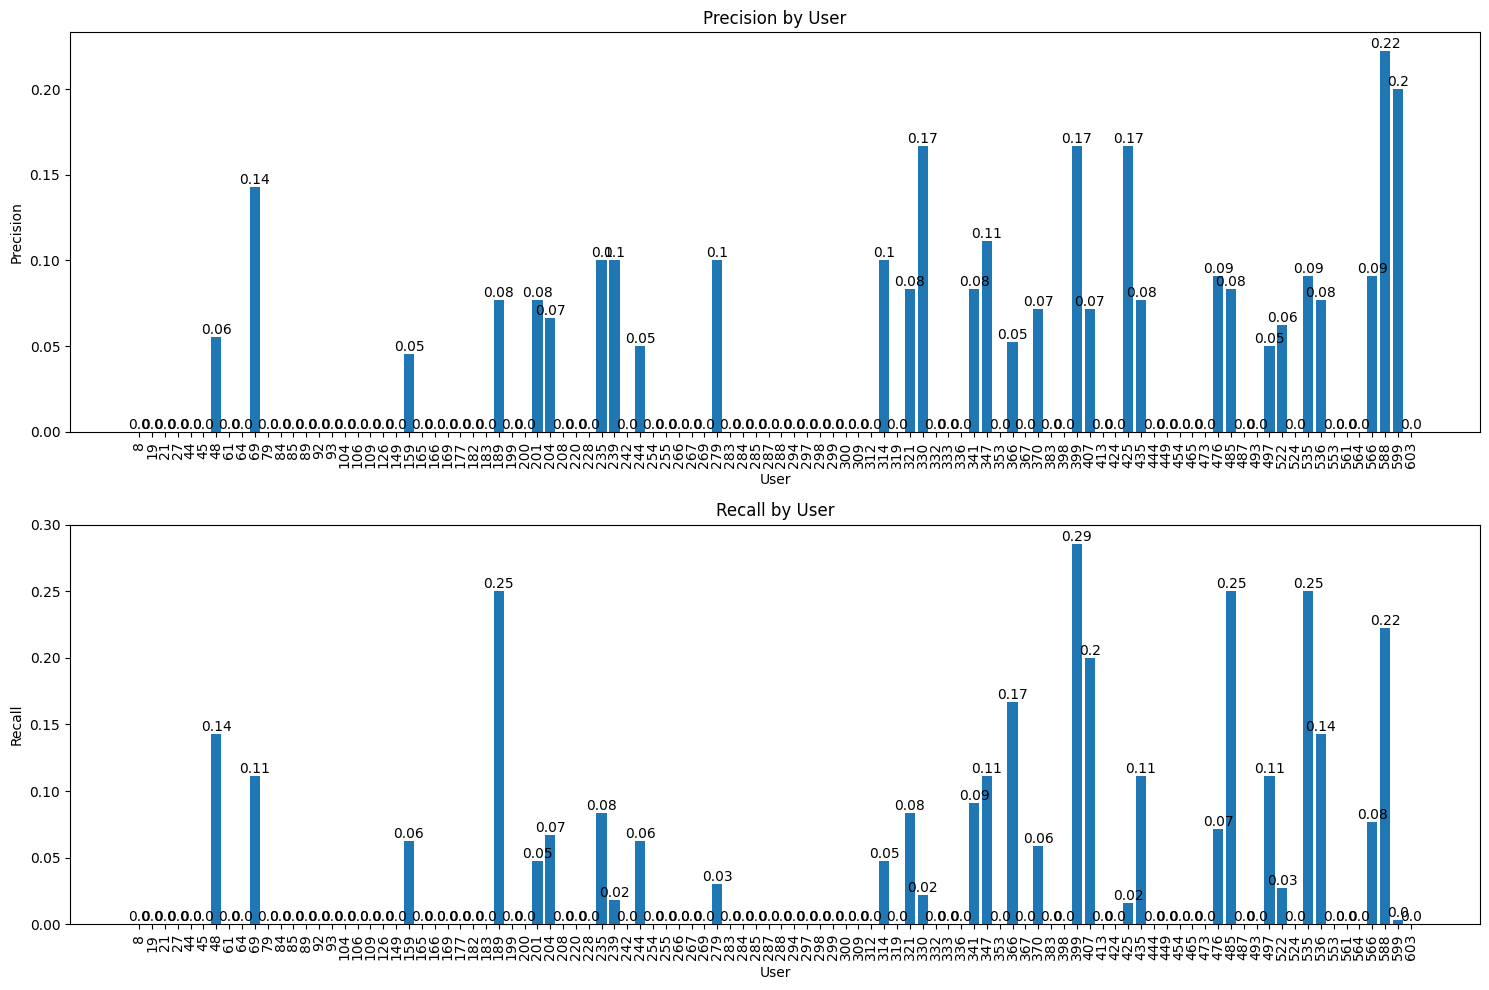

In [91]:
plt.figure(figsize=(15, 10))

# First plot for Precision
plt.subplot(2, 1, 1)
bars_precision = plt.bar(sample['userId'].astype(str), sample['precision'])
plt.xticks(rotation=90)
plt.title('Precision by User')
plt.xlabel('User')
plt.ylabel('Precision')

# Annotate the bars for Precision
for bar in bars_precision:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Second subplot for Recall
plt.subplot(2, 1, 2)
bars_recall = plt.bar(sample['userId'].astype(str), sample['recall'])
plt.xticks(rotation=90)
plt.title('Recall by User')
plt.xlabel('User')
plt.ylabel('Recall')

# Annotate the bars for Recall
for bar in bars_recall:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()